# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
# %cd OpticalEncoder
# !dir
# !git pull

In [3]:
# %pip install belashovplot
# %pip install optuna
# %pip install timm

In [4]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump
import torch
import numpy
import optuna
import timm
import pickle

C:\Users\uclap\Documents\Coding\Python\OpticalEncoder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FigureWidthHeight = (16, 16)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA GeForce RTX 3060 Ti


# Оптимизиция при оптимальной дистанции распространения

## Установка не изменяемых параметров

In [7]:
# Предпочтительные параметры
size = 50.0E-6
near_N = 300
near_length = 5.0E-3
wavelength = 500.0E-9
optuna_epochs = 1

# Параметры когерентности
spatial_coherence = 50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 7

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size

cppp = upper_integer(near_N * size / length)
N = int(length / size) * cppp

reference_distance = length * sqrt((size/wavelength)**2 - 1)

## Инициализация некогерентной обёртки

In [8]:
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length).to(device)

In [9]:
autocorr = autocorrelation(incoherent.sample(), dims=[1,2], mean_dim=0, split=mean_samples)

In [10]:
autocorr_radius, _ = correlation_circle(autocorr, limits=((-length/2,+length/2),(-length/2,+length/2)), percent=0.8)
incoherent_distribution, incoherent_distribution_values = distribution(incoherent.sample(), N=100, return_values=True)
incoherent_sample = incoherent.sample()[0].cpu()
print('Радиус автокорреляции:', engineering(autocorr_radius, 'м'))

Радиус автокорреляции: 16.722 мкм


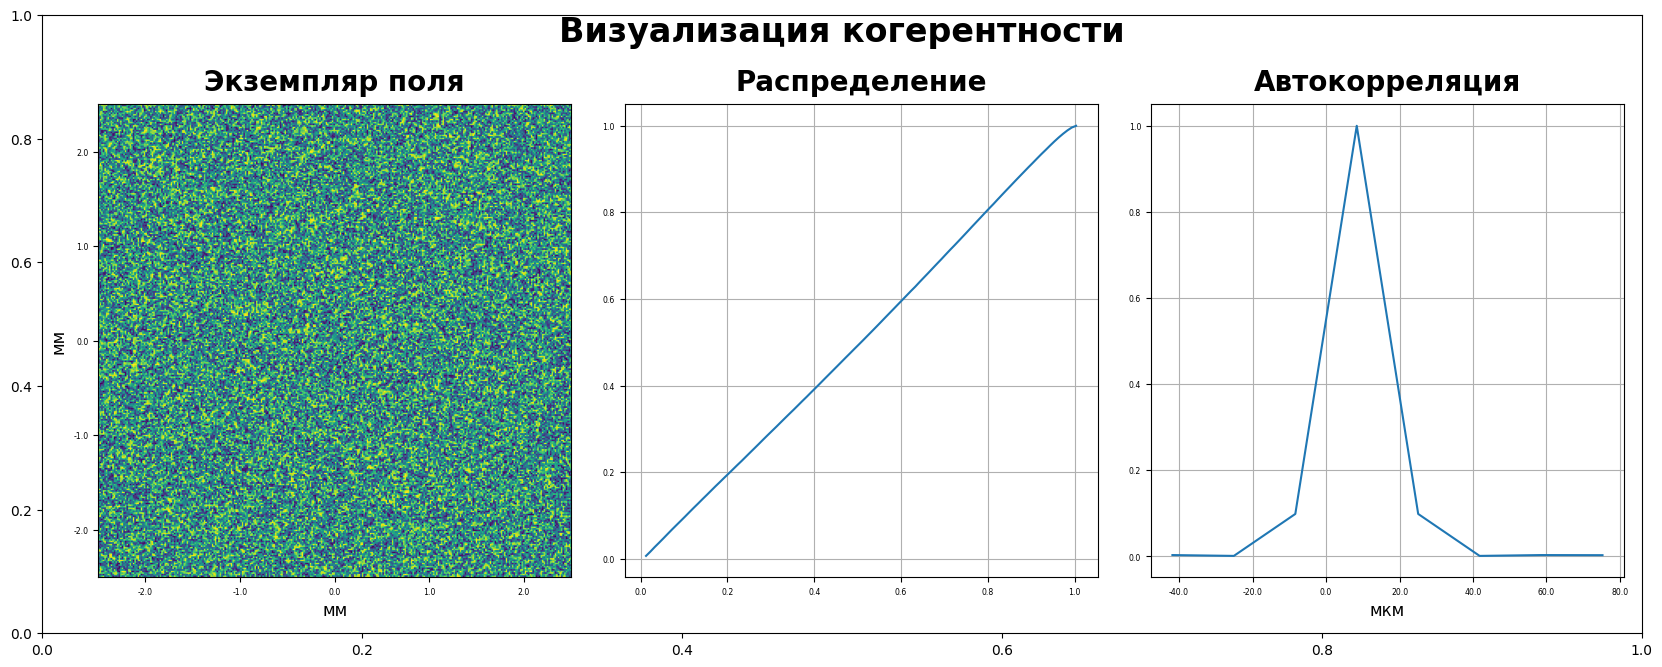

In [11]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Визуализация когерентности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')
formatter_rad, unit_rad = engineering.separatedformatter(autocorr_radius, 'м')

axes = plot.axes.add(0,0)
axes.imshow(incoherent_sample, aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)
plot.graph.title('Экземпляр поля')

axes = plot.axes.add(1,0)
axes.grid(True)
axes.plot(incoherent_distribution_values, incoherent_distribution.cpu())
plot.graph.title('Распределение')

p0 = int(autocorr.shape[1]*(1 - 4*autocorr_radius/length)/2)
p1 = p0 + int(8*autocorr.shape[1]*autocorr_radius/length)
axes = plot.axes.add(2,0)
axes.grid(True)
axes.plot(numpy.linspace(-length/2, +length/2, autocorr.shape[1])[p0:p1], autocorr[autocorr.shape[0]//2][p0:p1]/autocorr.max())
axes.xaxis.set_major_formatter(formatter_rad)
plot.graph.label.x(unit_rad)
plot.graph.title('Автокорреляция')

plot.show()

## Инициализация детекторов

In [12]:
detectors_amount = 24
detector_size = length / 60

spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((detector_size, detector_size), (0,0))
detectors = MatrixDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter).to(device)

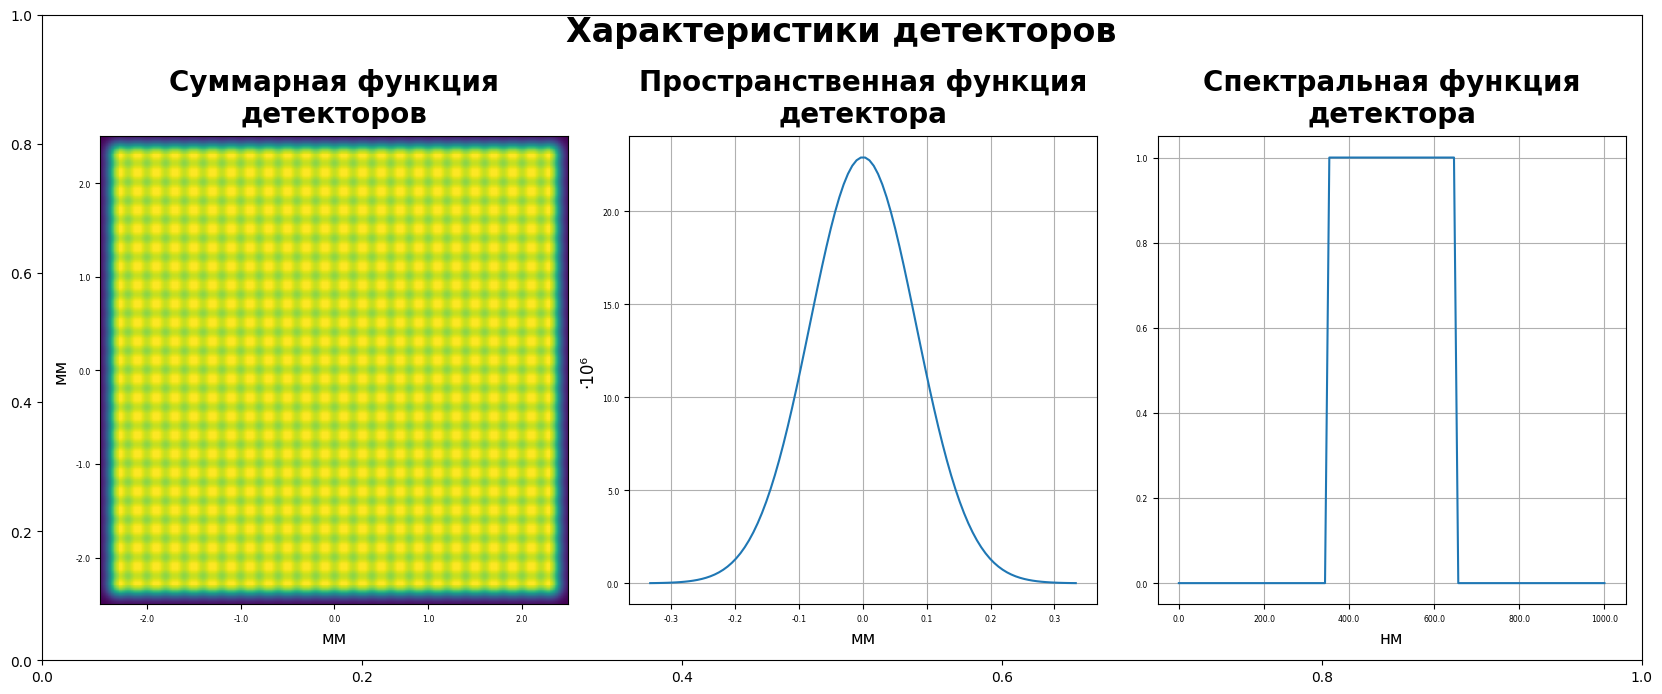

In [13]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.pad.graph.horizontal(0.1)
plot.title('Характеристики детекторов')

x_linspace = torch.linspace(-4*detector_size,+4*detector_size,100)
y_linspace = detectors_filter(x_linspace, x_linspace)[50]
wl_linspace = torch.linspace(0, 1000.0E-9, 100)
s_linspace = spectral_filter(wl_linspace)
formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')
formatter_d, unit_d = scientific.separatedformatter(y_linspace.max(), '')
formatter_wl, unit_wl = engineering.separatedformatter(wl_linspace.max(), 'м')

axes = plot.axes.add(0,0)
axes.imshow(detectors.filter, aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)
plot.graph.title('Суммарная функция детекторов')

axes = plot.axes.add(1,0)
axes.grid(True)
axes.plot(x_linspace, y_linspace)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_d)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_d)
plot.graph.title('Пространственная функция детектора')

axes = plot.axes.add(2,0)
axes.grid(True)
axes.plot(wl_linspace, s_linspace)
axes.xaxis.set_major_formatter(formatter_wl)
plot.graph.label.x(unit_wl)
plot.graph.title('Спектральная функция детектора')

plot.show()

## Инициализация электронной части

In [14]:
electronic = timm.create_model('resnet18', pretrained=True,  in_chans=1, num_classes=10).to(device)

## Комбинированная функция 

In [15]:
def combined_loss(cross_entropy_to_mse_proportion:float=1.0):
    def loss_function(outputs, targets):
        CELoss = torch.nn.functional.cross_entropy(outputs, targets)
        MSELoss = torch.nn.functional.mse_loss(torch.nn.functional.softmax(outputs, dim=1), torch.nn.functional.one_hot(targets, num_classes=10).float())
        loss = cross_entropy_to_mse_proportion*CELoss + (1.0-cross_entropy_to_mse_proportion)*MSELoss
        return loss
    return loss_function

## Выбор диапазона раcстояния распространения

In [16]:
# Настройка диапазона
distance_left_multiplier = 0.05
distance_right_multiplier = 0.5

slices = 100
distance_samples = 4
distance_array = numpy.linspace(reference_distance*distance_left_multiplier, reference_distance*distance_right_multiplier, distance_samples)

In [17]:
different_distance_propagations = []
# Вычисления
initial = torch.zeros((1, 1, N, N), device=device, dtype=torch.complex64)
p0 = N//2 - int(N*size/(length*2))
p1 = p0 + int(N*size/length)
initial[0,0,p0:p1,p0:p1] = 1.0

chunker = CudaMemoryChunker().to(device) 
with torch.no_grad():
    for max_distance in tqdm(distance_array):
        result = torch.zeros((slices, N), dtype=torch.float32)
        for i, distance in enumerate(numpy.linspace(0, max_distance, slices)):
            propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance).to(device)
            chunker.attach_forward(propagation.forward)
            incoherent.attach_forward(chunker.forward)
            result[i] = incoherent.forward(initial)[0,0,N//2].abs().cpu()
        different_distance_propagations.append((max_distance, result))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.77s/it]


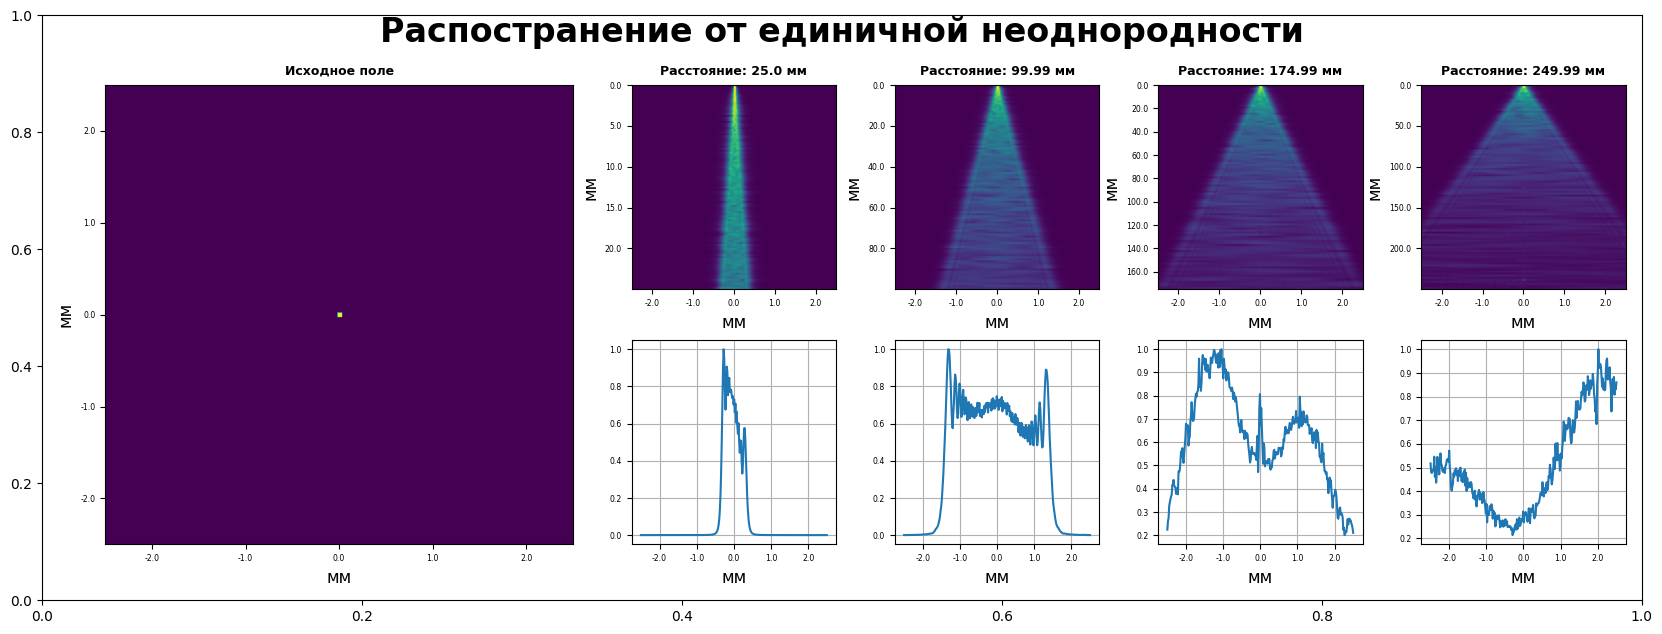

In [18]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Распостранение от единичной неоднородности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')

axes = plot.axes.add((0,0),(1,1))
axes.imshow(initial[0][0].abs().cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)

plot.description.column.top('Исходное поле',0,1)

for col, (distance, data) in enumerate(different_distance_propagations, 2):
    formatter_z, unit_z = engineering.separatedformatter(distance, 'м')
    plot.description.column.top(f"Расстояние: {engineering(distance,'м', 2)}", col)
    
    axes = plot.axes.add(col, 0)
    axes.imshow(torch.log10(data+0.0001), aspect='auto', extent=[-length/2,+length/2,distance,0])
    axes.xaxis.set_major_formatter(formatter_xy)
    axes.yaxis.set_major_formatter(formatter_z)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_z)

    axes = plot.axes.add(col,1)
    axes.grid(True)
    axes.plot(numpy.linspace(-length/2,+length/2,N), data[-1]/data[-1].max())
    axes.xaxis.set_major_formatter(formatter_xy)
    plot.graph.label.x(unit_xy)

plot.show()

## Вариации изменяемых параметров

In [19]:
# Установить вручную по картинкам выше (чем больше покрытие и меньше шумов, тем лучше)
distance_limits = (80.0E-3, 180.0E-3)

In [20]:
masks_amount_limits = (3, 10)
batch_size_limits = (20, 40)
learning_rate_limits = (0.00001, 0.1)
loss_functions_proportion_limits = (0.0, 1.0)
optimizer_types_list = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

## Вывод окончательных параметров

In [21]:
print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(size, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       300
Количество пикселей маски:                100
Размер оптических элементов:              5.0 мм
Размер пикселя маски:                     50.0 мкм
Расстояние между слоями:                  249.987 мм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           50.0 мкм
Количество усреднений:                    7


## Функция цели для optuna и оптимизация

In [22]:
def objective(trial:optuna.trial):
    masks_amount = trial.suggest_int('masks amount', *masks_amount_limits)
    batch_size = trial.suggest_int('batch size', *batch_size_limits)
    distance = trial.suggest_float('distance', *distance_limits)
    learning_rate = trial.suggest_float('learning rate', *learning_rate_limits, log=True)
    loss_functions_proportion = trial.suggest_float('cross entorpy proportion', *loss_functions_proportion_limits)
    optimizer_type = trial.suggest_categorical('optimizer type', optimizer_types_list.keys())

    print('Эксперимент:')
    print(f"\tКоличетсво масок:  {masks_amount}")
    print(f"\tРазмер батча:      {batch_size}")
    print(f"\tДистанция:         {engineering(distance, 'м')}")
    print(f"\tСкорость обучения: {learning_rate}")
    print(f"\tПропорция CELoss:  {loss_functions_proportion}")
    print(f"\tТип оптимизатора:  {optimizer_type}")

    #Инициализация электронной 
    electronic = timm.create_model('resnet18', pretrained=False,  in_chans=1, num_classes=10).to(device)
    
    # Инициализация оптической части и гибридной модели
    propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
    phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
    amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
    elements = [phase_modulators[0], amplitude_modulators[0]]
    for phase_modulator, amplitude_modulator in zip(phase_modulators[1:], amplitude_modulators[1:]):
        elements.append(propagation)
        elements.append(phase_modulator)
        elements.append(amplitude_modulator)
    elements.append(propagation)
    chunker = CudaMemoryChunker(sub_chunks=mean_samples)
    optical = CompositeModel(*elements)
    optical.wrap(chunker)
    optical.wrap(incoherent)
    optical.to(device)
    model = HybridModel(optical, detectors, electronic)
    
    # Подготовка данных, функции ошибки и оптимизатора
    dataset = Dataset('CIFAR10', batch_size, N, N, torch.complex64)
    dataset.train
    dataset.test
    loss_function = combined_loss(loss_functions_proportion)
    optimizer = optimizer_types_list[optimizer_type](model.parameters(), lr=learning_rate)

    # Обучение модели
    for i in range(optuna_epochs):
        train(model, dataset, optimizer, loss_function)
    confusion_matrix = confusion(model, dataset)
    return 100*numpy.sum(numpy.diagonal(confusion_matrix, 0))/numpy.sum(confusion_matrix)
study = optuna.create_study(study_name="ID2NN", storage="sqlite:///ID2NN.db", direction='maximize', load_if_exists=True)

[I 2024-05-06 09:41:28,307] Using an existing study with name 'ID2NN' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=100)

Эксперимент:
	Количетсво масок:  4
	Размер батча:      20
	Дистанция:         101.291 мм
	Скорость обучения: 0.006448133115208987
	Пропорция CELoss:  0.4978597178731138
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1139281176827325, RPI1000: -0.042285431280923345: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:36<00:00,  5.48it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.64it/s]
[I 2024-05-06 09:49:53,771] Trial 113 finished with value: 22.16 and parameters: {'masks amount': 4, 'batch size': 20, 'distance': 0.10129143781755194, 'learning rate': 0.006448133115208987, 'cross entorpy proportion': 0.4978597178731138, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      40
	Дистанция:         91.219 мм
	Скорость обучения: 0.007426822671099179
	Пропорция CELoss:  0.48768071832321613
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.040266336299021, RPI1000: -0.11100497333957701: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [07:43<00:00,  2.70it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:51<00:00,  4.82it/s]
[I 2024-05-06 09:58:31,107] Trial 114 finished with value: 23.7 and parameters: {'masks amount': 4, 'batch size': 40, 'distance': 0.09121854934389839, 'learning rate': 0.007426822671099179, 'cross entorpy proportion': 0.48768071832321613, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      37
	Дистанция:         90.983 мм
	Скорость обучения: 0.0072861678273201
	Пропорция CELoss:  0.3836664689069122
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.8521067225377408, RPI1000: -0.06859881215621183: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [06:10<00:00,  3.65it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:43<00:00,  6.24it/s]
[I 2024-05-06 10:05:27,230] Trial 115 finished with value: 21.02 and parameters: {'masks amount': 3, 'batch size': 37, 'distance': 0.09098277861988693, 'learning rate': 0.0072861678273201, 'cross entorpy proportion': 0.3836664689069122, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  8
	Размер батча:      39
	Дистанция:         90.445 мм
	Скорость обучения: 0.01065981373633032
	Пропорция CELoss:  0.33516588596217994
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.8159970111793776, RPI1000: -0.019724173427191256: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1283/1283 [13:28<00:00,  1.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [01:20<00:00,  3.18it/s]
[I 2024-05-06 10:20:18,165] Trial 116 finished with value: 10.0 and parameters: {'masks amount': 8, 'batch size': 39, 'distance': 0.09044528559436879, 'learning rate': 0.01065981373633032, 'cross entorpy proportion': 0.33516588596217994, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      40
	Дистанция:         119.537 мм
	Скорость обучения: 0.004782375227636914
	Пропорция CELoss:  0.018542853908224986
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.12362172231267297, RPI1000: -0.008335162752707053: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [09:02<00:00,  2.31it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:53<00:00,  4.68it/s]
[I 2024-05-06 10:30:15,824] Trial 117 finished with value: 20.7 and parameters: {'masks amount': 5, 'batch size': 40, 'distance': 0.11953720190531399, 'learning rate': 0.004782375227636914, 'cross entorpy proportion': 0.018542853908224986, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      22
	Дистанция:         84.402 мм
	Скорость обучения: 0.01816962661967526
	Пропорция CELoss:  0.5953066428846877
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.3169251587242836, RPI1000: -0.14459486399028246: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [07:20<00:00,  5.16it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:46<00:00,  9.75it/s]
[I 2024-05-06 10:38:25,294] Trial 118 finished with value: 20.14 and parameters: {'masks amount': 4, 'batch size': 22, 'distance': 0.08440206626461433, 'learning rate': 0.01816962661967526, 'cross entorpy proportion': 0.5953066428846877, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      28
	Дистанция:         109.968 мм
	Скорость обучения: 0.003975536426422089
	Пропорция CELoss:  0.24403138111771486
	Тип оптимизатора:  Adagrad
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.6051465507477682, RPI1000: -0.015778103524609458: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1786/1786 [09:17<00:00,  3.21it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 358/358 [00:53<00:00,  6.64it/s]
[I 2024-05-06 10:48:38,538] Trial 119 finished with value: 18.23 and parameters: {'masks amount': 5, 'batch size': 28, 'distance': 0.1099680718170107, 'learning rate': 0.003975536426422089, 'cross entorpy proportion': 0.24403138111771486, 'optimizer type': 'Adagrad'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      21
	Дистанция:         105.965 мм
	Скорость обучения: 0.013925388192682539
	Пропорция CELoss:  0.21201363013707702
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.4990561159723531, RPI1000: -0.023367838007042775: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [07:35<00:00,  5.23it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:48<00:00,  9.75it/s]
[I 2024-05-06 10:57:04,896] Trial 120 finished with value: 22.05 and parameters: {'masks amount': 4, 'batch size': 21, 'distance': 0.10596496466106242, 'learning rate': 0.013925388192682539, 'cross entorpy proportion': 0.21201363013707702, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      20
	Дистанция:         116.122 мм
	Скорость обучения: 0.006576310893744452
	Пропорция CELoss:  0.49600753654914076
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1066886302951175, RPI1000: -0.05041251963397734: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:40<00:00,  5.43it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:49<00:00, 10.08it/s]
[I 2024-05-06 11:05:37,067] Trial 121 finished with value: 23.47 and parameters: {'masks amount': 4, 'batch size': 20, 'distance': 0.11612224989513713, 'learning rate': 0.006576310893744452, 'cross entorpy proportion': 0.49600753654914076, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      20
	Дистанция:         116.087 мм
	Скорость обучения: 0.00837899760076691
	Пропорция CELoss:  0.4953163196567953
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1102910610278969, RPI1000: -0.04799293769345082: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:49<00:00,  5.32it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:48<00:00, 10.30it/s]
[I 2024-05-06 11:14:17,158] Trial 122 finished with value: 21.18 and parameters: {'masks amount': 4, 'batch size': 20, 'distance': 0.11608715341381556, 'learning rate': 0.00837899760076691, 'cross entorpy proportion': 0.4953163196567953, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      20
	Дистанция:         121.595 мм
	Скорость обучения: 0.005598311774459195
	Пропорция CELoss:  0.5387632503541908
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.231388464790193, RPI1000: -0.05159019527371093: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:27<00:00,  5.58it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.59it/s]
[I 2024-05-06 11:22:34,435] Trial 123 finished with value: 21.66 and parameters: {'masks amount': 4, 'batch size': 20, 'distance': 0.12159483899323081, 'learning rate': 0.005598311774459195, 'cross entorpy proportion': 0.5387632503541908, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         127.443 мм
	Скорость обучения: 0.010444803382579948
	Пропорция CELoss:  0.1860733125333377
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.4566715325561408, RPI1000: -0.01803422631417805: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:00<00:00,  6.60it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:39<00:00, 12.18it/s]
[I 2024-05-06 11:29:16,523] Trial 124 finished with value: 23.02 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.12744341323446637, 'learning rate': 0.010444803382579948, 'cross entorpy proportion': 0.1860733125333377, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         125.219 мм
	Скорость обучения: 0.009645293992565106
	Пропорция CELoss:  0.1648925619746364
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.41038528116509615, RPI1000: -0.01632021745972653: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:01<00:00,  6.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:39<00:00, 12.14it/s]
[I 2024-05-06 11:35:59,302] Trial 125 finished with value: 20.77 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.12521864359209783, 'learning rate': 0.009645293992565106, 'cross entorpy proportion': 0.1648925619746364, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      20
	Дистанция:         128.341 мм
	Скорость обучения: 0.01152489591444496
	Пропорция CELoss:  0.19988912780301907
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.5059467746552454, RPI1000: -0.019983313319871097: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:02<00:00,  6.90it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:39<00:00, 12.53it/s]
[I 2024-05-06 11:42:43,452] Trial 126 finished with value: 23.46 and parameters: {'masks amount': 3, 'batch size': 20, 'distance': 0.12834139356907065, 'learning rate': 0.01152489591444496, 'cross entorpy proportion': 0.19988912780301907, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         128.811 мм
	Скорость обучения: 0.011682063955768113
	Пропорция CELoss:  0.18005523125009082
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.464709774895851, RPI1000: -0.01985586015405436: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [05:55<00:00,  6.40it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:38<00:00, 11.76it/s]
[I 2024-05-06 11:49:19,337] Trial 127 finished with value: 21.57 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.12881136904237886, 'learning rate': 0.011682063955768113, 'cross entorpy proportion': 0.18005523125009082, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      23
	Дистанция:         132.454 мм
	Скорость обучения: 0.03723139252627308
	Пропорция CELoss:  0.12764695626269357
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.36164187097558875, RPI1000: -0.018017047820815958: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [05:50<00:00,  6.21it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:38<00:00, 11.29it/s]
[I 2024-05-06 11:55:49,927] Trial 128 finished with value: 14.2 and parameters: {'masks amount': 3, 'batch size': 23, 'distance': 0.13245428832537565, 'learning rate': 0.03723139252627308, 'cross entorpy proportion': 0.12764695626269357, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      24
	Дистанция:         126.39 мм
	Скорость обучения: 0.007050304621425196
	Пропорция CELoss:  0.18924019846687412
	Тип оптимизатора:  SGD
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.5009200835068623, RPI1000: -0.0026995523692851563: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2084/2084 [05:52<00:00,  5.92it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:39<00:00, 10.65it/s]
[I 2024-05-06 12:02:23,415] Trial 129 finished with value: 15.25 and parameters: {'masks amount': 3, 'batch size': 24, 'distance': 0.1263900821460355, 'learning rate': 0.007050304621425196, 'cross entorpy proportion': 0.18924019846687412, 'optimizer type': 'SGD'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         128.627 мм
	Скорость обучения: 0.015074867535792518
	Пропорция CELoss:  0.06417715252561672
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.2110252666582039, RPI1000: -0.008436895301212253: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:17<00:00,  6.31it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:40<00:00, 11.76it/s]
[I 2024-05-06 12:09:23,803] Trial 130 finished with value: 23.77 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.1286266192121282, 'learning rate': 0.015074867535792518, 'cross entorpy proportion': 0.06417715252561672, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         131.084 мм
	Скорость обучения: 0.014726553966498756
	Пропорция CELoss:  0.05551333857731369
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.19367373694829434, RPI1000: -0.008496245171726721: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:09<00:00,  6.45it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:40<00:00, 11.81it/s]
[I 2024-05-06 12:16:15,497] Trial 131 finished with value: 23.77 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.13108411178053078, 'learning rate': 0.014726553966498756, 'cross entorpy proportion': 0.05551333857731369, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      20
	Дистанция:         129.807 мм
	Скорость обучения: 0.01387237809712015
	Пропорция CELoss:  0.04815321617622843
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.18356855468980446, RPI1000: -0.006307668773057234: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:10<00:00,  6.75it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:40<00:00, 12.35it/s]
[I 2024-05-06 12:23:08,754] Trial 132 finished with value: 21.23 and parameters: {'masks amount': 3, 'batch size': 20, 'distance': 0.1298074391266058, 'learning rate': 0.01387237809712015, 'cross entorpy proportion': 0.04815321617622843, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         137.476 мм
	Скорость обучения: 0.02626551565020027
	Пропорция CELoss:  0.0621297406708708
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.2110353985743807, RPI1000: -0.008703809391026367: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:13<00:00,  6.37it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:41<00:00, 11.43it/s]
[I 2024-05-06 12:30:06,496] Trial 133 finished with value: 19.72 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.13747627496849643, 'learning rate': 0.02626551565020027, 'cross entorpy proportion': 0.0621297406708708, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      20
	Дистанция:         135.224 мм
	Скорость обучения: 0.017868308263695044
	Пропорция CELoss:  0.08562096576566788
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.25777932302523493, RPI1000: -0.009684538304952642: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:21<00:00,  6.55it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.64it/s]
[I 2024-05-06 12:37:13,611] Trial 134 finished with value: 16.4 and parameters: {'masks amount': 3, 'batch size': 20, 'distance': 0.13522406937901937, 'learning rate': 0.017868308263695044, 'cross entorpy proportion': 0.08562096576566788, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         127.283 мм
	Скорость обучения: 0.011467390317333818
	Пропорция CELoss:  0.02366383178323969
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1317353140048941, RPI1000: -0.0055636649780820375: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:17<00:00,  6.31it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:40<00:00, 11.75it/s]
[I 2024-05-06 12:44:13,724] Trial 135 finished with value: 24.26 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.12728321523819422, 'learning rate': 0.011467390317333818, 'cross entorpy proportion': 0.02366383178323969, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         127.557 мм
	Скорость обучения: 0.01161750167112188
	Пропорция CELoss:  0.024844298049345362
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1372381261578755, RPI1000: -0.00560569286683811: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:19<00:00,  6.27it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:40<00:00, 11.89it/s]
[I 2024-05-06 12:51:16,336] Trial 136 finished with value: 24.46 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.12755746562708606, 'learning rate': 0.01161750167112188, 'cross entorpy proportion': 0.024844298049345362, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         131.532 мм
	Скорость обучения: 0.05422622099610411
	Пропорция CELoss:  0.003958366136530115
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.098842785459512, RPI1000: -0.00231416477293841: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:21<00:00,  6.24it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:44<00:00, 10.70it/s]
[I 2024-05-06 12:58:24,737] Trial 137 finished with value: 10.18 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.1315319736303239, 'learning rate': 0.05422622099610411, 'cross entorpy proportion': 0.003958366136530115, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         134.556 мм
	Скорость обучения: 0.019633400185488183
	Пропорция CELoss:  0.027511088535161952
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.14247777253375093, RPI1000: -0.0044527877162961384: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:16<00:00,  6.03it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:40<00:00, 11.27it/s]
[I 2024-05-06 13:05:24,118] Trial 138 finished with value: 21.19 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.13455572175596106, 'learning rate': 0.019633400185488183, 'cross entorpy proportion': 0.027511088535161952, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      20
	Дистанция:         124.523 мм
	Скорость обучения: 0.01437671652415289
	Пропорция CELoss:  0.02817164650055695
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.14185749825112823, RPI1000: -0.004932606066061694: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:07<00:00,  6.80it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:40<00:00, 12.50it/s]
[I 2024-05-06 13:12:14,077] Trial 139 finished with value: 21.74 and parameters: {'masks amount': 3, 'batch size': 20, 'distance': 0.12452313171793696, 'learning rate': 0.01437671652415289, 'cross entorpy proportion': 0.02817164650055695, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         129.947 мм
	Скорость обучения: 0.03346188338091442
	Пропорция CELoss:  0.07196637300096807
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.23039873937482008, RPI1000: -0.010783558685015975: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:12<00:00,  6.40it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:43<00:00, 11.01it/s]
[I 2024-05-06 13:19:11,649] Trial 140 finished with value: 19.28 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.12994659860993646, 'learning rate': 0.03346188338091442, 'cross entorpy proportion': 0.07196637300096807, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         128.206 мм
	Скорость обучения: 0.0110316564326157
	Пропорция CELoss:  0.048160256587066706
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1820451057700642, RPI1000: -0.007121969664335314: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:20<00:00,  6.26it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:41<00:00, 11.61it/s]
[I 2024-05-06 13:26:15,301] Trial 141 finished with value: 23.42 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.12820590790980305, 'learning rate': 0.0110316564326157, 'cross entorpy proportion': 0.048160256587066706, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      20
	Дистанция:         128.221 мм
	Скорость обучения: 0.01093377024396741
	Пропорция CELoss:  0.043647734053161524
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.17347073261770837, RPI1000: -0.0069419525743925825: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:28<00:00,  6.44it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]
[I 2024-05-06 13:33:29,447] Trial 142 finished with value: 23.23 and parameters: {'masks amount': 3, 'batch size': 20, 'distance': 0.1282208896188025, 'learning rate': 0.01093377024396741, 'cross entorpy proportion': 0.043647734053161524, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      36
	Дистанция:         129.157 мм
	Скорость обучения: 0.011530548599465017
	Пропорция CELoss:  0.0015702372379878676
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.0874743748157864, RPI1000: -0.00630282211507414: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [06:16<00:00,  3.69it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:41<00:00,  6.71it/s]
[I 2024-05-06 13:40:29,508] Trial 143 finished with value: 20.53 and parameters: {'masks amount': 3, 'batch size': 36, 'distance': 0.12915719073063606, 'learning rate': 0.011530548599465017, 'cross entorpy proportion': 0.0015702372379878676, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         126.624 мм
	Скорость обучения: 0.01739167686635704
	Пропорция CELoss:  0.03355852684000182
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.15383933866822513, RPI1000: -0.006572169268264032: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:27<00:00,  5.86it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:42<00:00, 10.82it/s]
[I 2024-05-06 13:47:41,613] Trial 144 finished with value: 18.58 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.12662389681608602, 'learning rate': 0.01739167686635704, 'cross entorpy proportion': 0.03355852684000182, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      20
	Дистанция:         123.263 мм
	Скорость обучения: 0.01198425919199422
	Пропорция CELoss:  0.10841239584915781
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.29087442341432607, RPI1000: -0.011229381960961115: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:34<00:00,  6.34it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.13it/s]
[I 2024-05-06 13:55:03,398] Trial 145 finished with value: 19.4 and parameters: {'masks amount': 3, 'batch size': 20, 'distance': 0.12326271910944453, 'learning rate': 0.01198425919199422, 'cross entorpy proportion': 0.10841239584915781, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         131.957 мм
	Скорость обучения: 0.009923661443423644
	Пропорция CELoss:  0.0705951253973019
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.23061615983688616, RPI1000: -0.009249699403415305: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:30<00:00,  6.10it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:42<00:00, 11.15it/s]
[I 2024-05-06 14:02:19,226] Trial 146 finished with value: 22.67 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.1319566227229496, 'learning rate': 0.009923661443423644, 'cross entorpy proportion': 0.0705951253973019, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      20
	Дистанция:         128.032 мм
	Скорость обучения: 0.006918608750929025
	Пропорция CELoss:  0.01601880803232616
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1157292627332152, RPI1000: -0.004484495917885372: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:21<00:00,  6.55it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.74it/s]
[I 2024-05-06 14:09:25,999] Trial 147 finished with value: 23.79 and parameters: {'masks amount': 3, 'batch size': 20, 'distance': 0.12803210084878006, 'learning rate': 0.006918608750929025, 'cross entorpy proportion': 0.01601880803232616, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         136.854 мм
	Скорость обучения: 0.0066164991274395195
	Пропорция CELoss:  0.016943366452157493
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.11758192383178204, RPI1000: -0.005423678929879871: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:08<00:00,  6.45it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:41<00:00, 11.42it/s]
[I 2024-05-06 14:16:19,432] Trial 148 finished with value: 25.66 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.13685426075813728, 'learning rate': 0.0066164991274395195, 'cross entorpy proportion': 0.016943366452157493, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         136.14 мм
	Скорость обучения: 0.006051962482913687
	Пропорция CELoss:  0.01735681833526459
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.12580309376713708, RPI1000: -0.004974323325510898: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:15<00:00,  6.34it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:41<00:00, 11.52it/s]
[I 2024-05-06 14:23:18,386] Trial 149 finished with value: 22.47 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.13614036016488415, 'learning rate': 0.006051962482913687, 'cross entorpy proportion': 0.01735681833526459, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      33
	Дистанция:         133.595 мм
	Скорость обучения: 0.014174885385185732
	Пропорция CELoss:  0.019607006751682074
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1219804481133181, RPI1000: -0.01127074790573956: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1516/1516 [06:02<00:00,  4.18it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:40<00:00,  7.50it/s]
[I 2024-05-06 14:30:04,664] Trial 150 finished with value: 17.66 and parameters: {'masks amount': 3, 'batch size': 33, 'distance': 0.1335945868302351, 'learning rate': 0.014174885385185732, 'cross entorpy proportion': 0.019607006751682074, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         125.109 мм
	Скорость обучения: 0.0073399196579298194
	Пропорция CELoss:  0.05612074737544653
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1931279543537921, RPI1000: -0.009795832496441444: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:15<00:00,  6.34it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:41<00:00, 11.51it/s]
[I 2024-05-06 14:37:04,178] Trial 151 finished with value: 21.43 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.12510926865876026, 'learning rate': 0.0073399196579298194, 'cross entorpy proportion': 0.05612074737544653, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         130.993 мм
	Скорость обучения: 0.008437853256651405
	Пропорция CELoss:  0.0815788344112305
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.2456777083964119, RPI1000: -0.01558806193367333: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:13<00:00,  6.08it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:40<00:00, 11.14it/s]
[I 2024-05-06 14:44:00,981] Trial 152 finished with value: 24.37 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.13099298512298393, 'learning rate': 0.008437853256651405, 'cross entorpy proportion': 0.0815788344112305, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         131.057 мм
	Скорость обучения: 0.005001334586207864
	Пропорция CELoss:  0.08176735453533408
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.24724029670998354, RPI1000: -0.014213575721206056: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:23<00:00,  6.20it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:41<00:00, 11.57it/s]
[I 2024-05-06 14:51:08,243] Trial 153 finished with value: 23.28 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.13105666604276922, 'learning rate': 0.005001334586207864, 'cross entorpy proportion': 0.08176735453533408, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         138.773 мм
	Скорость обучения: 0.008735983910575344
	Пропорция CELoss:  0.0005424414405184545
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.08740356126679664, RPI1000: -0.006314215930633318: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:14<00:00,  6.07it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:39<00:00, 11.43it/s]
[I 2024-05-06 14:58:05,171] Trial 154 finished with value: 19.24 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.13877295734448036, 'learning rate': 0.008735983910575344, 'cross entorpy proportion': 0.0005424414405184545, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      20
	Дистанция:         128.876 мм
	Скорость обучения: 0.006746019194804271
	Пропорция CELoss:  0.04006594443354273
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1655043214845123, RPI1000: -0.007223063800744706: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:07<00:00,  6.80it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 12.09it/s]
[I 2024-05-06 15:04:56,205] Trial 155 finished with value: 21.08 and parameters: {'masks amount': 3, 'batch size': 20, 'distance': 0.12887638025600065, 'learning rate': 0.006746019194804271, 'cross entorpy proportion': 0.04006594443354273, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         136.51 мм
	Скорость обучения: 0.024412219088325488
	Пропорция CELoss:  0.059648576092951024
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.20379881756847767, RPI1000: -0.022927450706651906: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:21<00:00,  5.95it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:40<00:00, 11.12it/s]
[I 2024-05-06 15:12:01,303] Trial 156 finished with value: 20.69 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.13651039849933452, 'learning rate': 0.024412219088325488, 'cross entorpy proportion': 0.059648576092951024, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         140.53 мм
	Скорость обучения: 0.009565939037982894
	Пропорция CELoss:  0.02257488278851292
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.13271312017925294, RPI1000: -0.006454840546455074: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:04<00:00,  6.53it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:39<00:00, 11.99it/s]
[I 2024-05-06 15:18:47,902] Trial 157 finished with value: 22.59 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.14052998652583, 'learning rate': 0.009565939037982894, 'cross entorpy proportion': 0.02257488278851292, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      20
	Дистанция:         86.447 мм
	Скорость обучения: 0.015792183272367744
	Пропорция CELoss:  0.9033703788695432
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8956413822060125, RPI1000: -0.1464156210286303: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:12<00:00,  6.70it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.91it/s]
[I 2024-05-06 15:25:45,178] Trial 158 finished with value: 24.03 and parameters: {'masks amount': 3, 'batch size': 20, 'distance': 0.08644683652503807, 'learning rate': 0.015792183272367744, 'cross entorpy proportion': 0.9033703788695432, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      20
	Дистанция:         84.026 мм
	Скорость обучения: 0.017439067184694367
	Пропорция CELoss:  0.4850947210500449
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.0747403691035982, RPI1000: -0.08438400582908069: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:00<00:00,  6.93it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:39<00:00, 12.70it/s]
[I 2024-05-06 15:32:27,661] Trial 159 finished with value: 19.6 and parameters: {'masks amount': 3, 'batch size': 20, 'distance': 0.08402627146906011, 'learning rate': 0.017439067184694367, 'cross entorpy proportion': 0.4850947210500449, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      20
	Дистанция:         87.109 мм
	Скорость обучения: 0.021968634989458346
	Пропорция CELoss:  0.6953550552269431
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5063902584628444, RPI1000: -0.13663013994928985: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:09<00:00,  6.77it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 12.12it/s]
[I 2024-05-06 15:39:20,409] Trial 160 finished with value: 20.31 and parameters: {'masks amount': 3, 'batch size': 20, 'distance': 0.08710889104166272, 'learning rate': 0.021968634989458346, 'cross entorpy proportion': 0.6953550552269431, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         96.175 мм
	Скорость обучения: 0.01254044158151833
	Пропорция CELoss:  0.5413306961273934
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1350471622624339, RPI1000: -0.09146317927409708: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:16<00:00,  6.33it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:40<00:00, 11.90it/s]
[I 2024-05-06 15:46:18,979] Trial 161 finished with value: 24.67 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.09617452775292143, 'learning rate': 0.01254044158151833, 'cross entorpy proportion': 0.5413306961273934, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      20
	Дистанция:         87.876 мм
	Скорость обучения: 0.013667717067792965
	Пропорция CELoss:  0.82741991278342
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.6734154906257066, RPI1000: -0.13883643429151668: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:07<00:00,  6.81it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:40<00:00, 12.20it/s]
[I 2024-05-06 15:53:09,301] Trial 162 finished with value: 22.28 and parameters: {'masks amount': 3, 'batch size': 20, 'distance': 0.08787625804879447, 'learning rate': 0.013667717067792965, 'cross entorpy proportion': 0.82741991278342, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      20
	Дистанция:         96.057 мм
	Скорость обучения: 0.01542748852627312
	Пропорция CELoss:  0.5477259464942281
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1107128954221113, RPI1000: -0.09496279362876152: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:59<00:00,  5.96it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:50<00:00,  9.93it/s]
[I 2024-05-06 16:01:01,548] Trial 163 finished with value: 23.05 and parameters: {'masks amount': 3, 'batch size': 20, 'distance': 0.09605728960450165, 'learning rate': 0.01542748852627312, 'cross entorpy proportion': 0.5477259464942281, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         92.945 мм
	Скорость обучения: 0.00866017769698562
	Пропорция CELoss:  0.9034357924149257
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8600678343927113, RPI1000: -0.12706312245109425: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:57<00:00,  5.70it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:45<00:00, 10.38it/s]
[I 2024-05-06 16:08:47,449] Trial 164 finished with value: 23.18 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.09294469946366841, 'learning rate': 0.00866017769698562, 'cross entorpy proportion': 0.9034357924149257, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         87.757 мм
	Скорость обучения: 0.006165120513287425
	Пропорция CELoss:  0.08759444368851736
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.2558157123757706, RPI1000: -0.014328514702228833: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:45<00:00,  5.61it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:45<00:00,  9.94it/s]
[I 2024-05-06 16:16:20,871] Trial 165 finished with value: 23.71 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.08775719971495397, 'learning rate': 0.006165120513287425, 'cross entorpy proportion': 0.08759444368851736, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      23
	Дистанция:         86.894 мм
	Скорость обучения: 0.006199634642856325
	Пропорция CELoss:  0.9576631481158983
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.0279229362632756, RPI1000: -0.13889654810905125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [06:21<00:00,  5.70it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:41<00:00, 10.58it/s]
[I 2024-05-06 16:23:25,329] Trial 166 finished with value: 23.09 and parameters: {'masks amount': 3, 'batch size': 23, 'distance': 0.0868937684070587, 'learning rate': 0.006199634642856325, 'cross entorpy proportion': 0.9576631481158983, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         90.666 мм
	Скорость обучения: 0.004336333656907814
	Пропорция CELoss:  0.7133074314807764
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5060486669377389, RPI1000: -0.08869357407725213: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:15<00:00,  6.06it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:41<00:00, 10.84it/s]
[I 2024-05-06 16:30:25,057] Trial 167 finished with value: 18.96 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.09066590782798169, 'learning rate': 0.004336333656907814, 'cross entorpy proportion': 0.7133074314807764, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         82.307 мм
	Скорость обучения: 0.005315438341781667
	Пропорция CELoss:  0.5162440207933621
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.0740772488311396, RPI1000: -0.06666674366080955: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:08<00:00,  6.17it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:40<00:00, 11.35it/s]
[I 2024-05-06 16:37:15,970] Trial 168 finished with value: 25.15 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.08230658319435034, 'learning rate': 0.005315438341781667, 'cross entorpy proportion': 0.5162440207933621, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      23
	Дистанция:         88.81 мм
	Скорость обучения: 0.00527108836728437
	Пропорция CELoss:  0.08880910232183799
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.26125264187871694, RPI1000: -0.0179540182910428: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [06:10<00:00,  5.86it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:41<00:00, 10.49it/s]
[I 2024-05-06 16:44:10,386] Trial 169 finished with value: 21.53 and parameters: {'masks amount': 3, 'batch size': 23, 'distance': 0.0888097733461942, 'learning rate': 0.00527108836728437, 'cross entorpy proportion': 0.08880910232183799, 'optimizer type': 'RMSprop'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         81.026 мм
	Скорость обучения: 0.006970910800640707
	Пропорция CELoss:  0.5856503936116786
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.2469644510216051, RPI1000: -0.09012072785219262: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:08<00:00,  6.18it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:42<00:00, 10.66it/s]
[I 2024-05-06 16:51:03,447] Trial 170 finished with value: 27.02 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.08102636883083275, 'learning rate': 0.006970910800640707, 'cross entorpy proportion': 0.5856503936116786, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         81.426 мм
	Скорость обучения: 0.006857337154871537
	Пропорция CELoss:  0.6118948301967496
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.2874176546509384, RPI1000: -0.07752225055390316: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:22<00:00,  5.94it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:43<00:00, 10.35it/s]
[I 2024-05-06 16:58:12,468] Trial 171 finished with value: 22.41 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.08142605503352796, 'learning rate': 0.006857337154871537, 'cross entorpy proportion': 0.6118948301967496, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         85.644 мм
	Скорость обучения: 0.0055733259689188875
	Пропорция CELoss:  0.018136782349255483
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.12246208804469239, RPI1000: -0.005049283267072965: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:11<00:00,  6.12it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:40<00:00, 11.17it/s]
[I 2024-05-06 17:05:06,934] Trial 172 finished with value: 20.19 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.08564385201451567, 'learning rate': 0.0055733259689188875, 'cross entorpy proportion': 0.018136782349255483, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      23
	Дистанция:         81.961 мм
	Скорость обучения: 0.007905840475063791
	Пропорция CELoss:  0.51559865653547
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1023985638439484, RPI1000: -0.08403500660851679: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [06:11<00:00,  5.86it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:42<00:00, 10.35it/s]
[I 2024-05-06 17:12:02,524] Trial 173 finished with value: 24.92 and parameters: {'masks amount': 3, 'batch size': 23, 'distance': 0.08196100669242828, 'learning rate': 0.007905840475063791, 'cross entorpy proportion': 0.51559865653547, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      23
	Дистанция:         81.428 мм
	Скорость обучения: 0.009153296160266715
	Пропорция CELoss:  0.5509753767304209
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1812589075206508, RPI1000: -0.07584922548532277: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [06:12<00:00,  5.83it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:41<00:00, 10.44it/s]
[I 2024-05-06 17:18:59,147] Trial 174 finished with value: 21.7 and parameters: {'masks amount': 3, 'batch size': 23, 'distance': 0.08142768935485663, 'learning rate': 0.009153296160266715, 'cross entorpy proportion': 0.5509753767304209, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         82.134 мм
	Скорость обучения: 0.01278222578555574
	Пропорция CELoss:  0.5140289762319054
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1438722633118008, RPI1000: -0.09179871563375998: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:17<00:00,  6.02it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:42<00:00, 10.66it/s]
[I 2024-05-06 17:26:01,639] Trial 175 finished with value: 19.31 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.08213398690110504, 'learning rate': 0.01278222578555574, 'cross entorpy proportion': 0.5140289762319054, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      23
	Дистанция:         80.208 мм
	Скорость обучения: 0.007850292998724818
	Пропорция CELoss:  0.5228840581187196
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1206078410519804, RPI1000: -0.07219613199865653: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [06:06<00:00,  5.93it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:39<00:00, 10.96it/s]
[I 2024-05-06 17:32:50,261] Trial 176 finished with value: 20.65 and parameters: {'masks amount': 3, 'batch size': 23, 'distance': 0.08020822985593709, 'learning rate': 0.007850292998724818, 'cross entorpy proportion': 0.5228840581187196, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      21
	Дистанция:         83.798 мм
	Скорость обучения: 0.020134907328716124
	Пропорция CELoss:  0.569336177796005
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.2753149869780918, RPI1000: -0.1395020772851029: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [06:53<00:00,  5.76it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:47<00:00, 10.14it/s]
[I 2024-05-06 17:40:33,067] Trial 177 finished with value: 22.2 and parameters: {'masks amount': 3, 'batch size': 21, 'distance': 0.083797711696416, 'learning rate': 0.020134907328716124, 'cross entorpy proportion': 0.569336177796005, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      24
	Дистанция:         92.684 мм
	Скорость обучения: 0.004005094632542962
	Пропорция CELoss:  0.0004800852584969425
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.083321694100024, RPI1000: -0.006479874913340767: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2084/2084 [06:50<00:00,  5.08it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:47<00:00,  8.74it/s]
[I 2024-05-06 17:48:13,110] Trial 178 finished with value: 23.78 and parameters: {'masks amount': 3, 'batch size': 24, 'distance': 0.09268368333674616, 'learning rate': 0.004005094632542962, 'cross entorpy proportion': 0.0004800852584969425, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      24
	Дистанция:         92.743 мм
	Скорость обучения: 0.004329839423561734
	Пропорция CELoss:  0.0011989147396091627
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.08914608325491971, RPI1000: -0.004636868664892229: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2084/2084 [06:57<00:00,  4.99it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:47<00:00,  8.86it/s]
[I 2024-05-06 17:56:00,072] Trial 179 finished with value: 22.23 and parameters: {'masks amount': 3, 'batch size': 24, 'distance': 0.09274258546868247, 'learning rate': 0.004329839423561734, 'cross entorpy proportion': 0.0011989147396091627, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      23
	Дистанция:         97.057 мм
	Скорость обучения: 3.291326503820168e-05
	Пропорция CELoss:  0.035144697558928344
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1611347432362931, RPI1000: -0.0021304930107517643: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [06:36<00:00,  5.48it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:41<00:00, 10.54it/s]
[I 2024-05-06 18:03:20,142] Trial 180 finished with value: 21.36 and parameters: {'masks amount': 3, 'batch size': 23, 'distance': 0.09705735602220965, 'learning rate': 3.291326503820168e-05, 'cross entorpy proportion': 0.035144697558928344, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         89.594 мм
	Скорость обучения: 0.009616541680258842
	Пропорция CELoss:  0.06569624588804472
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.21811037373378248, RPI1000: -0.011974643598603662: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:21<00:00,  5.95it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:44<00:00, 10.12it/s]
[I 2024-05-06 18:10:28,967] Trial 181 finished with value: 22.1 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.08959395127410791, 'learning rate': 0.009616541680258842, 'cross entorpy proportion': 0.06569624588804472, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         100.905 мм
	Скорость обучения: 0.0034967915994303287
	Пропорция CELoss:  0.86153554677705
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8648521907126154, RPI1000: -0.11725202911218506: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:43<00:00,  5.63it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:46<00:00,  9.73it/s]
[I 2024-05-06 18:18:01,617] Trial 182 finished with value: 25.01 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.10090507806753576, 'learning rate': 0.0034967915994303287, 'cross entorpy proportion': 0.86153554677705, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         85.158 мм
	Скорость обучения: 0.0048339870266504905
	Пропорция CELoss:  0.9109956829433808
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.804035213290975, RPI1000: -0.1329997571377602: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:48<00:00,  5.56it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:42<00:00, 10.64it/s]
[I 2024-05-06 18:25:35,423] Trial 183 finished with value: 24.42 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.08515845259940479, 'learning rate': 0.0048339870266504905, 'cross entorpy proportion': 0.9109956829433808, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      23
	Дистанция:         83.716 мм
	Скорость обучения: 0.003107577143246599
	Пропорция CELoss:  0.8924458755486466
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9127400260250722, RPI1000: -0.09775812440139812: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [06:38<00:00,  5.45it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:45<00:00,  9.62it/s]
[I 2024-05-06 18:33:01,445] Trial 184 finished with value: 19.82 and parameters: {'masks amount': 3, 'batch size': 23, 'distance': 0.08371595435643209, 'learning rate': 0.003107577143246599, 'cross entorpy proportion': 0.8924458755486466, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         82.408 мм
	Скорость обучения: 0.003772404687658559
	Пропорция CELoss:  0.9186956714116948
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8878954311035474, RPI1000: -0.13184021953677352: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:45<00:00,  5.60it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:42<00:00, 10.65it/s]
[I 2024-05-06 18:40:32,428] Trial 185 finished with value: 26.56 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.08240796639588503, 'learning rate': 0.003772404687658559, 'cross entorpy proportion': 0.9186956714116948, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      24
	Дистанция:         83.009 мм
	Скорость обучения: 0.002956769217220643
	Пропорция CELoss:  0.9126302551723092
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8414055205961544, RPI1000: -0.1398144011185325: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2084/2084 [06:44<00:00,  5.15it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:43<00:00,  9.68it/s]
[I 2024-05-06 18:48:02,180] Trial 186 finished with value: 23.6 and parameters: {'masks amount': 3, 'batch size': 24, 'distance': 0.08300878014129406, 'learning rate': 0.002956769217220643, 'cross entorpy proportion': 0.9126302551723092, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         99.823 мм
	Скорость обучения: 0.003937405390168328
	Пропорция CELoss:  0.8529659832739375
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8262638663925335, RPI1000: -0.1270586002484981: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:51<00:00,  5.52it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:44<00:00, 10.31it/s]
[I 2024-05-06 18:55:39,821] Trial 187 finished with value: 24.5 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.0998229978633843, 'learning rate': 0.003937405390168328, 'cross entorpy proportion': 0.8529659832739375, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         95.459 мм
	Скорость обучения: 0.003886301299295567
	Пропорция CELoss:  0.8713527965529467
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7624690650697696, RPI1000: -0.12453672250833825: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:29<00:00,  5.84it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:48<00:00,  9.33it/s]
[I 2024-05-06 19:03:00,140] Trial 188 finished with value: 23.79 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.09545899001794354, 'learning rate': 0.003886301299295567, 'cross entorpy proportion': 0.8713527965529467, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         99.276 мм
	Скорость обучения: 0.0034206114157906216
	Пропорция CELoss:  0.8440969066357008
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8072785153480109, RPI1000: -0.12507977039878018: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:59<00:00,  5.42it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:39<00:00, 11.48it/s]
[I 2024-05-06 19:10:41,643] Trial 189 finished with value: 24.5 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.09927563963568217, 'learning rate': 0.0034206114157906216, 'cross entorpy proportion': 0.8440969066357008, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         98.14 мм
	Скорость обучения: 0.0033638331351738228
	Пропорция CELoss:  0.8447734334976083
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7575313704350037, RPI1000: -0.13083215142117527: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:09<00:00,  6.15it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:41<00:00, 11.07it/s]
[I 2024-05-06 19:17:34,160] Trial 190 finished with value: 23.74 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.09814024813227187, 'learning rate': 0.0033638331351738228, 'cross entorpy proportion': 0.8447734334976083, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         101.06 мм
	Скорость обучения: 0.003681959138834086
	Пропорция CELoss:  0.8545965385539409
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7884575314058864, RPI1000: -0.11014399000953833: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [06:27<00:00,  5.87it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:42<00:00, 10.67it/s]
[I 2024-05-06 19:24:46,102] Trial 191 finished with value: 23.21 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.10106037759485738, 'learning rate': 0.003681959138834086, 'cross entorpy proportion': 0.8545965385539409, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      23
	Дистанция:         95.535 мм
	Скорость обучения: 0.004931799156843197
	Пропорция CELoss:  0.8849303745257091
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8890268796454286, RPI1000: -0.11514063608703934: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [06:13<00:00,  5.82it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:45<00:00,  9.51it/s]
[I 2024-05-06 19:31:47,560] Trial 192 finished with value: 25.01 and parameters: {'masks amount': 3, 'batch size': 23, 'distance': 0.09553525446951268, 'learning rate': 0.004931799156843197, 'cross entorpy proportion': 0.8849303745257091, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      23
	Дистанция:         100.725 мм
	Скорость обучения: 0.004846448928598164
	Пропорция CELoss:  0.8985586683222638
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8600724702049931, RPI1000: -0.14904140458694806: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [06:10<00:00,  5.87it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:39<00:00, 10.96it/s]
[I 2024-05-06 19:38:39,629] Trial 193 finished with value: 24.07 and parameters: {'masks amount': 3, 'batch size': 23, 'distance': 0.10072536187358537, 'learning rate': 0.004846448928598164, 'cross entorpy proportion': 0.8985586683222638, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      23
	Дистанция:         99.797 мм
	Скорость обучения: 0.0049286804196655674
	Пропорция CELoss:  0.9224166773024325
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9438612864351532, RPI1000: -0.1070801107681505: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [06:06<00:00,  5.92it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:42<00:00, 10.30it/s]
[I 2024-05-06 19:45:30,899] Trial 194 finished with value: 23.87 and parameters: {'masks amount': 3, 'batch size': 23, 'distance': 0.0997971027340674, 'learning rate': 0.0049286804196655674, 'cross entorpy proportion': 0.9224166773024325, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      23
	Дистанция:         103.05 мм
	Скорость обучения: 0.004641236231096518
	Пропорция CELoss:  0.877696747409929
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8109710326239223, RPI1000: -0.14039738973250648: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [06:32<00:00,  5.54it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:44<00:00,  9.82it/s]
[I 2024-05-06 19:52:49,310] Trial 195 finished with value: 25.3 and parameters: {'masks amount': 3, 'batch size': 23, 'distance': 0.10305008158152397, 'learning rate': 0.004641236231096518, 'cross entorpy proportion': 0.877696747409929, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      23
	Дистанция:         102.911 мм
	Скорость обучения: 0.005069625926392267
	Пропорция CELoss:  0.9278375258365538
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9589086414279469, RPI1000: -0.12658591621336793: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [06:16<00:00,  5.77it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:40<00:00, 10.74it/s]
[I 2024-05-06 19:59:48,365] Trial 196 finished with value: 23.01 and parameters: {'masks amount': 3, 'batch size': 23, 'distance': 0.10291064566252632, 'learning rate': 0.005069625926392267, 'cross entorpy proportion': 0.9278375258365538, 'optimizer type': 'RMSprop'}. Best is trial 170 with value: 27.02.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      23
	Дистанция:         99.41 мм
	Скорость обучения: 0.004312814476931223
	Пропорция CELoss:  0.8794583035620499
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.751917828102748, RPI1000: -0.14886520233607248:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1829/2174 [05:24<00:57,  5.99it/s]

In [ ]:
print("Лучшие гиперпараметры:", study.best_trial.params)

In [ ]:
len(study.trials)